<a href="https://colab.research.google.com/github/Feugang/steve/blob/master/Feze.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow_text

In [2]:
import numpy as np

import typing
from typing import Any, Tuple

import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing

import tensorflow_text as tf_text

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


In [3]:
use_builtins = True

In [4]:
class ShapeChecker():
  def __init__(self):
    # Keep a cache of every axis-name seen
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    if isinstance(names, str):
      names = (names,)

    shape = tf.shape(tensor)
    rank = tf.rank(tensor)

    if rank != len(names):
      raise ValueError(f'Rank mismatch:\n'
                       f'    found {rank}: {shape.numpy()}\n'
                       f'    expected {len(names)}: {names}\n')

    for i, name in enumerate(names):
      if isinstance(name, int):
        old_dim = name
      else:
        old_dim = self.shapes.get(name, None)
      new_dim = shape[i]

      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        # If the axis name is new, add its length to the cache.
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")


In [6]:
import pandas as pd
from google.colab import files
files.upload()


Saving edgar.txt to edgar.txt


{'edgar.txt': b'Go.\tVa !\r\nHi.\tSalut !\r\nRun!\tCours\xe2\x80\xaf!\r\nRun!\tCourez\xe2\x80\xaf!\r\nWho?\tQui ?\r\nWow!\t\xc3\x87a alors\xe2\x80\xaf!\r\nFire!\tAu feu !\r\nHelp!\t\xc3\x80 l\'aide\xe2\x80\xaf!\r\nJump.\tSaute.\r\nStop!\t\xc3\x87a suffit\xe2\x80\xaf!\r\nStop!\tStop\xe2\x80\xaf!\r\nStop!\tArr\xc3\xaate-toi !\r\nWait!\tAttends !\r\nWait!\tAttendez !\r\nGo on.\tPoursuis.\r\nGo on.\tContinuez.\r\nGo on.\tPoursuivez.\r\nHello!\tBonjour !\r\nHello!\tSalut !\r\nI see.\tJe comprends.\r\nI try.\tJ\'essaye.\r\nI won!\tJ\'ai gagn\xc3\xa9 !\r\nI won!\tJe l\'ai emport\xc3\xa9 !\r\nI won.\tJ\xe2\x80\x99ai gagn\xc3\xa9.\r\nOh no!\tOh non !\r\nAttack!\tAttaque !\r\nAttack!\tAttaquez !\r\nCheers!\tSant\xc3\xa9 !\r\nCheers!\t\xc3\x80 votre sant\xc3\xa9 !\r\nCheers!\tMerci !\r\nCheers!\tTchin-tchin !\r\nGet up.\tL\xc3\xa8ve-toi.\r\nGo now.\tVa, maintenant.\r\nGo now.\tAllez-y maintenant.\r\nGo now.\tVas-y maintenant.\r\nGot it!\tJ\'ai pig\xc3\xa9 !\r\nGot it!\tCompris !\r\nGot it?\tPig\x

In [ ]:
path_to_file = pd.read_csv("/content/edgar.txt", sep= '\t', header= None, names=['source', 'cible'])
inp = path_to_file.source
targ = path_to_file.cible
print(inp)
#print(path_to_file)

In [8]:
print(targ[1000:1067])

1000         Qui est-il ?
1001           Qui sait ?
1002        Qui a parlé ?
1003            Qui ira ?
1004     C’est qui, Tom ?
              ...        
1062     Soyez prudente !
1063     Soyez prudents !
1064    Soyez prudentes !
1065     Sois satisfait !
1066    Sois satisfaite !
Name: cible, Length: 67, dtype: object


In [9]:
BUFFER_SIZE = len(inp)
BATCH_SIZE = 64

dataset = tf.data.Dataset.from_tensor_slices((inp, targ)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)


In [ ]:
for example_input_batch, example_target_batch in dataset.take(1):
  print(example_input_batch[:5])
  print()
  print(example_target_batch[:5])
  break


In [11]:
example_text = tf.constant(inp[13456])

print(example_text.numpy())
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())


b'I ran out of gas.'
b'I ran out of gas.'


In [12]:
def tf_lower_and_split_punct(text):
  # Split accecented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text


In [ ]:
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())


In [14]:
import pathlib
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

np.set_printoptions(precision=4)

In [15]:
inp = tf.data.Dataset.from_tensor_slices(inp)

In [16]:
targ= tf.data.Dataset.from_tensor_slices(targ)

In [17]:
max_vocab_size = 5000

input_text_processor = preprocessing.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size)


In [ ]:
input_text_processor.adapt(inp)

# Here are the first 10 words from the vocabulary:
input_text_processor.get_vocabulary()[:10]


In [ ]:
output_text_processor = preprocessing.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size)

output_text_processor.adapt(targ)
output_text_processor.get_vocabulary()[:10]


In [ ]:
example_tokens = input_text_processor(example_input_batch)
example_tokens[:3, :10]

In [ ]:
input_vocab = np.array(input_text_processor.get_vocabulary())
tokens = input_vocab[example_tokens[0].numpy()]
' '.join(tokens)


In [ ]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens)
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')


In [23]:
embedding_dim = 256
units = 1024


In [24]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, input_vocab_size, embedding_dim, enc_units):
    super(Encoder, self).__init__()
    self.enc_units = enc_units
    self.input_vocab_size = input_vocab_size

    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.input_vocab_size,
                                               embedding_dim)

    # The GRU RNN layer processes those vectors sequentially.
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   # Return the sequence and state
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, tokens, state=None):
    shape_checker = ShapeChecker()
    shape_checker(tokens, ('batch', 's'))

    # 2. The embedding layer looks up the embedding for each token.
    vectors = self.embedding(tokens)
    shape_checker(vectors, ('batch', 's', 'embed_dim'))

    # 3. The GRU processes the embedding sequence.
    #    output shape: (batch, s, enc_units)
    #    state shape: (batch, enc_units)
    output, state = self.gru(vectors, initial_state=state)
    shape_checker(output, ('batch', 's', 'enc_units'))
    shape_checker(state, ('batch', 'enc_units'))

    # 4. Returns the new sequence and its state.
    return output, state


In [ ]:
# Convert the input text to tokens.
example_tokens = input_text_processor(example_input_batch)

# Encode the input sequence.
encoder = Encoder(input_text_processor.vocabulary_size(),
                  embedding_dim, units)
example_enc_output, example_enc_state = encoder(example_tokens)

print(f'Input batch, shape (batch): {example_input_batch.shape}')
print(f'Input batch tokens, shape (batch, s): {example_tokens.shape}')
print(f'Encoder output, shape (batch, s, units): {example_enc_output.shape}')
print(f'Encoder state, shape (batch, units): {example_enc_state.shape}')


In [26]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super().__init__()
    # For Eqn. (4), the  Bahdanau attention
    self.W1 = tf.keras.layers.Dense(units, use_bias=False)
    self.W2 = tf.keras.layers.Dense(units, use_bias=False)

    self.attention = tf.keras.layers.AdditiveAttention()

  def call(self, query, value, mask):
    shape_checker = ShapeChecker()
    shape_checker(query, ('batch', 't', 'query_units'))
    shape_checker(value, ('batch', 's', 'value_units'))
    shape_checker(mask, ('batch', 's'))

    # From Eqn. (4), `W1@ht`.
    w1_query = self.W1(query)
    shape_checker(w1_query, ('batch', 't', 'attn_units'))

    # From Eqn. (4), `W2@hs`.
    w2_key = self.W2(value)
    shape_checker(w2_key, ('batch', 's', 'attn_units'))

    query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
    value_mask = mask

    context_vector, attention_weights = self.attention(
        inputs = [w1_query, value, w2_key],
        mask=[query_mask, value_mask],
        return_attention_scores = True,
    )
    shape_checker(context_vector, ('batch', 't', 'value_units'))
    shape_checker(attention_weights, ('batch', 't', 's'))

    return context_vector, attention_weights


In [27]:
attention_layer = BahdanauAttention(units)


In [28]:
(example_tokens != 0).shape

TensorShape([64, 8])

In [29]:
# Later, the decoder will generate this attention query
example_attention_query = tf.random.normal(shape=[len(example_tokens), 2, 10])

# Attend to the encoded tokens

context_vector, attention_weights = attention_layer(
    query=example_attention_query,
    value=example_enc_output,
    mask=(example_tokens != 0))

print(f'Attention result shape: (batch_size, query_seq_length, units):           {context_vector.shape}')
print(f'Attention weights shape: (batch_size, query_seq_length, value_seq_length): {attention_weights.shape}')


Attention result shape: (batch_size, query_seq_length, units):           (64, 2, 1024)
Attention weights shape: (batch_size, query_seq_length, value_seq_length): (64, 2, 8)


Text(0.5, 1.0, 'Mask')

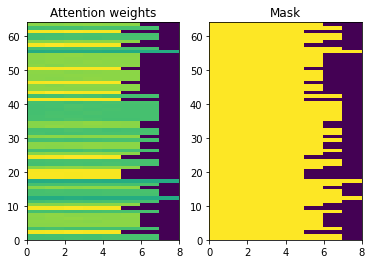

In [30]:
plt.subplot(1, 2, 1)
plt.pcolormesh(attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')


In [31]:
attention_weights.shape

TensorShape([64, 2, 8])

In [32]:
attention_slice = attention_weights[0, 0].numpy()
attention_slice = attention_slice[attention_slice != 0]

<Figure size 432x288 with 0 Axes>

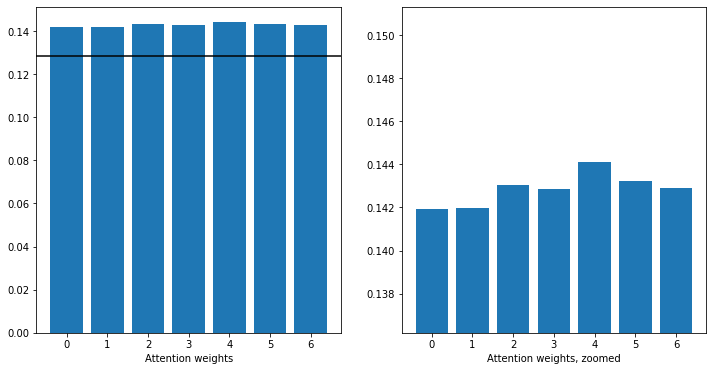

In [33]:
plt.suptitle('Attention weights for one sequence')

plt.figure(figsize=(12, 6))
a1 = plt.subplot(1, 2, 1)
plt.bar(range(len(attention_slice)), attention_slice)
# freeze the xlim
plt.xlim(plt.xlim())
plt.xlabel('Attention weights')

a2 = plt.subplot(1, 2, 2)
plt.bar(range(len(attention_slice)), attention_slice)
plt.xlabel('Attention weights, zoomed')

# zoom in
top = max(a1.get_ylim())
zoom = 0.85*top
a2.set_ylim([0.90*top, top])
a1.plot(a1.get_xlim(), [zoom, zoom], color='k')


In [34]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, output_vocab_size, embedding_dim, dec_units):
    super(Decoder, self).__init__()
    self.dec_units = dec_units
    self.output_vocab_size = output_vocab_size
    self.embedding_dim = embedding_dim

    # For Step 1. The embedding layer convets token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.output_vocab_size,
                                               embedding_dim)

    # For Step 2. The RNN keeps track of what's been generated so far.
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # For step 3. The RNN output will be the query for the attention layer.
    self.attention = BahdanauAttention(self.dec_units)

    # For step 4. Eqn. (3): converting `ct` to `at`
    self.Wc = tf.keras.layers.Dense(dec_units, activation=tf.math.tanh,
                                    use_bias=False)

    # For step 5. This fully connected layer produces the logits for each
    # output token.
    self.fc = tf.keras.layers.Dense(self.output_vocab_size)


In [35]:
class DecoderInput(typing.NamedTuple):
  new_tokens: Any
  enc_output: Any
  mask: Any

class DecoderOutput(typing.NamedTuple):
  logits: Any
  attention_weights: Any


In [36]:
def call(self,
         inputs: DecoderInput,
         state=None) -> Tuple[DecoderOutput, tf.Tensor]:
  shape_checker = ShapeChecker()
  shape_checker(inputs.new_tokens, ('batch', 't'))
  shape_checker(inputs.enc_output, ('batch', 's', 'enc_units'))
  shape_checker(inputs.mask, ('batch', 's'))

  if state is not None:
    shape_checker(state, ('batch', 'dec_units'))

  # Step 1. Lookup the embeddings
  vectors = self.embedding(inputs.new_tokens)
  shape_checker(vectors, ('batch', 't', 'embedding_dim'))

  # Step 2. Process one step with the RNN
  rnn_output, state = self.gru(vectors, initial_state=state)

  shape_checker(rnn_output, ('batch', 't', 'dec_units'))
  shape_checker(state, ('batch', 'dec_units'))

  # Step 3. Use the RNN output as the query for the attention over the
  # encoder output.
  context_vector, attention_weights = self.attention(
      query=rnn_output, value=inputs.enc_output, mask=inputs.mask)
  shape_checker(context_vector, ('batch', 't', 'dec_units'))
  shape_checker(attention_weights, ('batch', 't', 's'))

  # Step 4. Eqn. (3): Join the context_vector and rnn_output
  #     [ct; ht] shape: (batch t, value_units + query_units)
  context_and_rnn_output = tf.concat([context_vector, rnn_output], axis=-1)

  # Step 4. Eqn. (3): `at = tanh(Wc@[ct; ht])`
  attention_vector = self.Wc(context_and_rnn_output)
  shape_checker(attention_vector, ('batch', 't', 'dec_units'))

  # Step 5. Generate logit predictions:
  logits = self.fc(attention_vector)
  shape_checker(logits, ('batch', 't', 'output_vocab_size'))

  return DecoderOutput(logits, attention_weights), state


In [37]:
Decoder.call = call

In [38]:
decoder = Decoder(output_text_processor.vocabulary_size(),
                  embedding_dim, units)


In [39]:
# Convert the target sequence, and collect the "[START]" tokens
example_output_tokens = output_text_processor(example_target_batch)

start_index = output_text_processor._index_lookup_layer('[START]').numpy()
first_token = tf.constant([[start_index]] * example_output_tokens.shape[0])


In [40]:
# Run the decoder
dec_result, dec_state = decoder(
    inputs = DecoderInput(new_tokens=first_token,
                          enc_output=example_enc_output,
                          mask=(example_tokens != 0)),
    state = example_enc_state
)

print(f'logits shape: (batch_size, t, output_vocab_size) {dec_result.logits.shape}')
print(f'state shape: (batch_size, dec_units) {dec_state.shape}')


logits shape: (batch_size, t, output_vocab_size) (64, 1, 5000)
state shape: (batch_size, dec_units) (64, 1024)


In [41]:
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)

In [42]:
vocab = np.array(output_text_processor.get_vocabulary())
first_word = vocab[sampled_token.numpy()]
first_word[:5]


array([['prevaudra'],
       ['tattendrai'],
       ['nappela'],
       ['sabotage'],
       ['pourquoi']], dtype='<U15')

In [43]:
dec_result, dec_state = decoder(
    DecoderInput(sampled_token,
                 example_enc_output,
                 mask=(example_tokens != 0)),
    state=dec_state)

In [44]:
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)
first_word = vocab[sampled_token.numpy()]
first_word[:5]


array([['plante'],
       ['ecouter'],
       ['etudiante'],
       ['vends'],
       ['saignait']], dtype='<U15')

In [45]:
class MaskedLoss(tf.keras.losses.Loss):
  def __init__(self):
    self.name = 'masked_loss'
    self.loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')

  def __call__(self, y_true, y_pred):
    shape_checker = ShapeChecker()
    shape_checker(y_true, ('batch', 't'))
    shape_checker(y_pred, ('batch', 't', 'logits'))

    # Calculate the loss for each item in the batch.
    loss = self.loss(y_true, y_pred)
    shape_checker(loss, ('batch', 't'))

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, tf.float32)
    shape_checker(mask, ('batch', 't'))
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)


In [46]:
class TrainTranslator(tf.keras.Model):
  def __init__(self, embedding_dim, units,
               input_text_processor,
               output_text_processor, 
               use_tf_function=True):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(input_text_processor.vocabulary_size(),
                      embedding_dim, units)
    decoder = Decoder(output_text_processor.vocabulary_size(),
                      embedding_dim, units)

    self.encoder = encoder
    self.decoder = decoder
    self.input_text_processor = input_text_processor
    self.output_text_processor = output_text_processor
    self.use_tf_function = use_tf_function
    self.shape_checker = ShapeChecker()

  def train_step(self, inputs):
    self.shape_checker = ShapeChecker()
    if self.use_tf_function:
      return self._tf_train_step(inputs)
    else:
      return self._train_step(inputs)


In [47]:
def _preprocess(self, input_text, target_text):
  self.shape_checker(input_text, ('batch',))
  self.shape_checker(target_text, ('batch',))

  # Convert the text to token IDs
  input_tokens = self.input_text_processor(input_text)
  target_tokens = self.output_text_processor(target_text)
  self.shape_checker(input_tokens, ('batch', 's'))
  self.shape_checker(target_tokens, ('batch', 't'))

  # Convert IDs to masks.
  input_mask = input_tokens != 0
  self.shape_checker(input_mask, ('batch', 's'))

  target_mask = target_tokens != 0
  self.shape_checker(target_mask, ('batch', 't'))

  return input_tokens, input_mask, target_tokens, target_mask


In [48]:
TrainTranslator._preprocess = _preprocess


In [49]:
def _train_step(self, inputs):
  input_text, target_text = inputs  

  (input_tokens, input_mask,
   target_tokens, target_mask) = self._preprocess(input_text, target_text)

  max_target_length = tf.shape(target_tokens)[1]

  with tf.GradientTape() as tape:
    # Encode the input
    enc_output, enc_state = self.encoder(input_tokens)
    self.shape_checker(enc_output, ('batch', 's', 'enc_units'))
    self.shape_checker(enc_state, ('batch', 'enc_units'))

    # Initialize the decoder's state to the encoder's final state.
    # This only works if the encoder and decoder have the same number of
    # units.
    dec_state = enc_state
    loss = tf.constant(0.0)

    for t in tf.range(max_target_length-1):
      # Pass in two tokens from the target sequence:
      # 1. The current input to the decoder.
      # 2. The target the target for the decoder's next prediction.
      new_tokens = target_tokens[:, t:t+2]
      step_loss, dec_state = self._loop_step(new_tokens, input_mask,
                                             enc_output, dec_state)
      loss = loss + step_loss

    # Average the loss over all non padding tokens.
    average_loss = loss / tf.reduce_sum(tf.cast(target_mask, tf.float32))

  # Apply an optimization step
  variables = self.trainable_variables 
  gradients = tape.gradient(average_loss, variables)
  self.optimizer.apply_gradients(zip(gradients, variables))

  # Return a dict mapping metric names to current value
  return {'batch_loss': average_loss}


In [50]:
TrainTranslator._train_step = _train_step


In [51]:
def _loop_step(self, new_tokens, input_mask, enc_output, dec_state):
  input_token, target_token = new_tokens[:, 0:1], new_tokens[:, 1:2]

  # Run the decoder one step.
  decoder_input = DecoderInput(new_tokens=input_token,
                               enc_output=enc_output,
                               mask=input_mask)

  dec_result, dec_state = self.decoder(decoder_input, state=dec_state)
  self.shape_checker(dec_result.logits, ('batch', 't1', 'logits'))
  self.shape_checker(dec_result.attention_weights, ('batch', 't1', 's'))
  self.shape_checker(dec_state, ('batch', 'dec_units'))

  # `self.loss` returns the total for non-padded tokens
  y = target_token
  y_pred = dec_result.logits
  step_loss = self.loss(y, y_pred)

  return step_loss, dec_state


In [52]:
TrainTranslator._loop_step = _loop_step

In [53]:
translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
    use_tf_function=False)

# Configure the loss and optimizer
translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)


In [54]:
np.log(output_text_processor.vocabulary_size())


8.517193191416238

In [55]:
%%time
for n in range(20):
  print(translator.train_step([example_input_batch, example_target_batch]))
print()


{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.254718>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.216394>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.144324>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=6.9580836>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=6.4254193>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.914275>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=6.1006274>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.392159>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.9020326>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.9265943>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.964055>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.82769>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.646928>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.505916>}
{'batch_loss': <tf.Tensor: sha

In [56]:
@tf.function(input_signature=[[tf.TensorSpec(dtype=tf.string, shape=[None]),
                               tf.TensorSpec(dtype=tf.string, shape=[None])]])
def _tf_train_step(self, inputs):
  return self._train_step(inputs)


In [57]:
TrainTranslator._tf_train_step = _tf_train_step


In [58]:
translator.use_tf_function = True


In [59]:
translator.train_step([example_input_batch, example_target_batch])


{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2931762>}

In [60]:
%%time
for n in range(50):
  print(translator.train_step([example_input_batch, example_target_batch]))
print()


{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.257333>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2147443>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.1771412>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.1454294>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.1166673>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.089734>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.0634212>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.0354722>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.004738>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=2.9721127>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=2.9398031>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=2.9103794>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=2.885829>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=2.8656497>}
{'batch_loss': <tf.Tenso

....................................................................................................


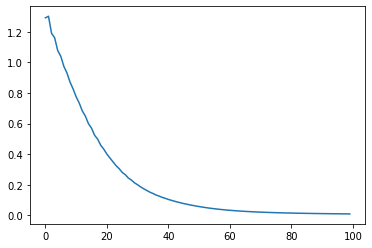

In [61]:
losses = []
for n in range(100):
  print('.', end='')
  logs = translator.train_step([example_input_batch, example_target_batch])
  losses.append(logs['batch_loss'].numpy())

print()
plt.plot(losses)


In [62]:
train_translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor)

# Configure the loss and optimizer
train_translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)


In [63]:
class BatchLogs(tf.keras.callbacks.Callback):
  def __init__(self, key):
    self.key = key
    self.logs = []

  def on_train_batch_end(self, n, logs):
    self.logs.append(logs[self.key])

batch_loss = BatchLogs('batch_loss')


In [ ]:
train_translator.fit(dataset, epochs=25,
                     callbacks=[batch_loss])

Text(0, 0.5, 'CE/token')

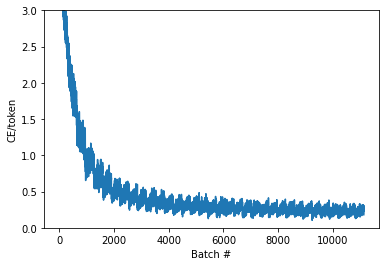

In [66]:
plt.plot(batch_loss.logs)
plt.ylim([0, 3])
plt.xlabel('Batch #')
plt.ylabel('CE/token')


In [67]:
class Translator(tf.Module):
  def __init__(self,
               encoder, decoder, 
               input_text_processor,
               output_text_processor):
    self.encoder = encoder
    self.decoder = decoder
    self.input_text_processor = input_text_processor
    self.output_text_processor = output_text_processor

    self.output_token_string_from_index = (
        tf.keras.layers.experimental.preprocessing.StringLookup(
            vocabulary=output_text_processor.get_vocabulary(),
            invert=True))

    # The output should never generate padding, unknown, or start.
    index_from_string = tf.keras.layers.experimental.preprocessing.StringLookup(
        vocabulary=output_text_processor.get_vocabulary())
    token_mask_ids = index_from_string(['',
                                        '[UNK]',
                                        '[START]']).numpy()

    token_mask = np.zeros([index_from_string.vocabulary_size()], dtype=np.bool)
    token_mask[np.array(token_mask_ids)] = True
    self.token_mask = token_mask

    self.start_token = index_from_string('[START]')
    self.end_token = index_from_string('[END]')


In [68]:
translator = Translator(
    encoder=train_translator.encoder,
    decoder=train_translator.decoder,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
)


In [69]:
def tokens_to_text(self, result_tokens):
  shape_checker = ShapeChecker()
  shape_checker(result_tokens, ('batch', 't'))
  result_text_tokens = self.output_token_string_from_index(result_tokens)
  shape_checker(result_text_tokens, ('batch', 't'))

  result_text = tf.strings.reduce_join(result_text_tokens,
                                       axis=1, separator=' ')
  shape_checker(result_text, ('batch'))

  result_text = tf.strings.strip(result_text)
  shape_checker(result_text, ('batch',))
  return result_text


In [70]:
Translator.tokens_to_text = tokens_to_text


In [71]:
example_output_tokens = tf.random.uniform(
    shape=[5, 2], minval=0, dtype=tf.int64,
    maxval=output_text_processor.vocabulary_size())
translator.tokens_to_text(example_output_tokens).numpy()


array([b'noirs requiers', b'intention loup', b'connaissez diteslui',
       b'depasse ete', b'trahi rendeznous'], dtype=object)

In [72]:
def sample(self, logits, temperature):
  shape_checker = ShapeChecker()
  # 't' is usually 1 here.
  shape_checker(logits, ('batch', 't', 'vocab'))
  shape_checker(self.token_mask, ('vocab',))

  token_mask = self.token_mask[tf.newaxis, tf.newaxis, :]
  shape_checker(token_mask, ('batch', 't', 'vocab'), broadcast=True)

  # Set the logits for all masked tokens to -inf, so they are never chosen.
  logits = tf.where(self.token_mask, -np.inf, logits)

  if temperature == 0.0:
    new_tokens = tf.argmax(logits, axis=-1)
  else: 
    logits = tf.squeeze(logits, axis=1)
    new_tokens = tf.random.categorical(logits/temperature,
                                        num_samples=1)

  shape_checker(new_tokens, ('batch', 't'))

  return new_tokens


In [74]:
Translator.sample = sample

In [75]:
example_logits = tf.random.normal([5, 1, output_text_processor.vocabulary_size()])
example_output_tokens = translator.sample(example_logits, temperature=1.0)
example_output_tokens


<tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[4663],
       [ 362],
       [3347],
       [1450],
       [2808]])>

In [76]:
def translate_unrolled(self,
                       input_text, *,
                       max_length=50,
                       return_attention=True,
                       temperature=1.0):
  batch_size = tf.shape(input_text)[0]
  input_tokens = self.input_text_processor(input_text)
  enc_output, enc_state = self.encoder(input_tokens)

  dec_state = enc_state
  new_tokens = tf.fill([batch_size, 1], self.start_token)

  result_tokens = []
  attention = []
  done = tf.zeros([batch_size, 1], dtype=tf.bool)

  for _ in range(max_length):
    dec_input = DecoderInput(new_tokens=new_tokens,
                             enc_output=enc_output,
                             mask=(input_tokens!=0))

    dec_result, dec_state = self.decoder(dec_input, state=dec_state)

    attention.append(dec_result.attention_weights)

    new_tokens = self.sample(dec_result.logits, temperature)

    # If a sequence produces an `end_token`, set it `done`
    done = done | (new_tokens == self.end_token)
    # Once a sequence is done it only produces 0-padding.
    new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)

    # Collect the generated tokens
    result_tokens.append(new_tokens)

    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Convert the list of generates token ids to a list of strings.
  result_tokens = tf.concat(result_tokens, axis=-1)
  result_text = self.tokens_to_text(result_tokens)

  if return_attention:
    attention_stack = tf.concat(attention, axis=1)
    return {'text': result_text, 'attention': attention_stack}
  else:
    return {'text': result_text}


In [77]:
Translator.translate = translate_unrolled

In [82]:
%%time
input_text = tf.constant([
    "She loves this boy.", # "It's really cold here."
    'This is my life.', # "This is my life.""
])

result = translator.translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()


elle laime bien .
cest ma vie .

CPU times: user 292 ms, sys: 5.97 ms, total: 298 ms
Wall time: 260 ms


In [83]:
f = tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
def tf_translate(self, input_text):
  return self.translate(input_text)

Translator.tf_translate = tf_translate


In [84]:
%%time
result = translator.tf_translate(
    input_text = input_text)


CPU times: user 317 ms, sys: 13 ms, total: 330 ms
Wall time: 264 ms


In [85]:
%%time
result = translator.tf_translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

elle adorent ce garcon .
cest ma vie .

CPU times: user 374 ms, sys: 6.08 ms, total: 380 ms
Wall time: 315 ms
